In [1]:
%matplotlib inline
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import groupby
from sklearn import datasets
from scipy.stats import dirichlet, norm, poisson

np.random.seed(1234)

/Users/tdhopper/miniconda/envs/understanding-lda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


# Understanding Probabilistic Topic Models By Simulation

* Tim Hopper
* [@tdhopper](https://twitter.com/tdhopper)
* Data Science at [Distil Networks](distilnetworks.com)

Slides available at https://github.com/tdhopper/pydata-nyc-2015

# What is Latent Dirichlet Allocation?

> LDA is a three-level hierarchical Bayesian model, in which each
item of a collection is modeled as a finite mixture over an underlying set of topics. 

> Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities.

Duh.

[[source](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf)]

# What is Latent Dirichlet Allocation?

![](./static/graphical_model.png)

Duh.

# What is Latent Dirichlet Allocation?

$$
p(D \,|\, \alpha, \beta) =
\prod_{d=1}^M \int p(\theta_d \,|\, \alpha 
\left(
\prod_{n=1}^{N_d}
\sum_{z_{dn}}
p(z_{dn} \,|\, \theta_d)
p(w_dn \,|\, z_dn, \beta)
\right)
d \theta_d
$$

Duh.

![](./static/sheldon.gif)

In [2]:
iris = datasets.load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df['class'] = iris['target']
df = df[df['class'].isin([0,2])]
gby = df.groupby(by='class')['sepal length (cm)']
hist_data = [gby.get_group(cid).tolist() 
             for cid in gby.groups.keys()]

settings = {"bins": 10, "histtype": 'stepfilled', "alpha": .5}
data = {"x": df['sepal length (cm)']}
data.update(settings)
data2 = {"x": hist_data }
data2.update(settings)
title = 'Sepal Length for Iris-Setosa and Iris-Virginica'

# Gaussian Mixture Models

Can we discriminate between Setosa and Virginica irises by modeling their sepal length as a mixture of Gaussians?

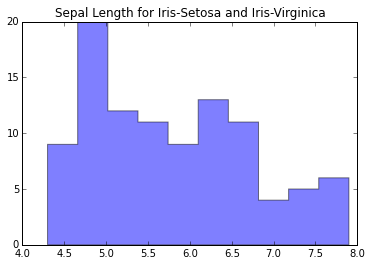

In [3]:
plt.hist(**data);_=plt.title(title)

# Gaussian Mixture Models

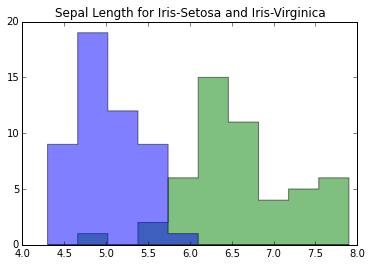

In [4]:
plt.hist(**data2);_=plt.title(title)

    ➡ Forward Sampling
    
Let's generate some data

In [5]:
# Fixed model parameters
mixture_proportion = [0.50, 0.50]
mean               = [5.01, 6.59]
std                = [0.35, 0.64]

data = []
for z in range(1, 101):
    iris_type = np.random.choice(2, p=mixture_proportion)
    sepal_length = norm(loc=mean[iris_type], scale=std[iris_type]).rvs()
    data.append((iris_type, sepal_length))

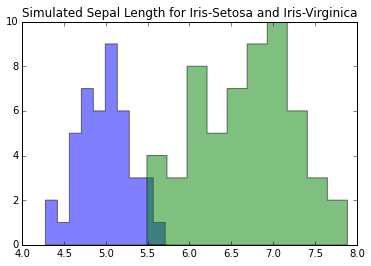

In [6]:
plt.hist([sepal_length for iris_type, sepal_length in data if iris_type==0], **settings)
plt.hist([sepal_length for iris_type, sepal_length in data if iris_type==1], **settings)
_=plt.title('Simulated Sepal Length for Iris-Setosa and Iris-Virginica')

    ➡ Forward Sampling
    
Bayesian style!

In [7]:
# Prior distribution on parameters
mixture_proportion = dirichlet(alpha=[1, 1]).rvs()[0]
mean               = norm(loc=6, scale=1).rvs(size=2)
std                = norm(loc=.5, scale=.2).rvs(size=2)

data = []
for z in range(1, 101):
    iris_type = np.random.choice(2, p=mixture_proportion)
    sepal_length = norm(loc=mean[iris_type], scale=std[iris_type]).rvs()
    data.append((iris_type, sepal_length))

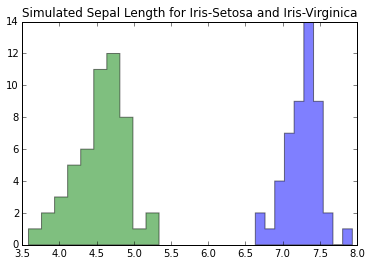

In [8]:
plt.hist([sepal_length for iris_type, sepal_length in data if iris_type==0], **settings)
plt.hist([sepal_length for iris_type, sepal_length in data if iris_type==1], **settings)
_=plt.title('Simulated Sepal Length for Iris-Setosa and Iris-Virginica')

    """
    ⬅ Reversing the Process
    """

Given data without cluster assignments...

...find the cluster for each point

...find the parameters of each cluster (or distribution over parameters)

...find the mixture proportion (or distribution proportions)

[You can do exactly this with PyMC3.](https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/gaussian_mixture_model.ipynb)

# Discrete Mixture Models

In [9]:
num_clusters = 2
mixture_proportion = dirichlet(alpha=num_clusters*[1]).rvs()[0]
cluster_distributions = dirichlet(alpha=[1, 1, 1]).rvs(size=num_clusters)

docs = defaultdict(str)
for z in range(100):
    cluster = np.random.choice(num_clusters, p=mixture_proportion)
    docs[cluster] += np.random.choice(['🐭', '🐘', '🐒'], 
                                      p=cluster_distributions[cluster])
    docs[cluster] = ''.join(sorted(docs[cluster]))

In [10]:
for cluster, doc in docs.items():
    print(end="Cluster {}: ".format(cluster+1))
    print(doc)

Cluster 1: 🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐘🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭
Cluster 2: 🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐘🐘🐘🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭🐭


## Mixture Model for Documents


In [11]:
vocabulary = ['🐍', '🐼', '📊']
boring_vocabulary = [':snake:', ':panda_face:', ':computer:']
num_terms = len(vocabulary)

# Topics are distributions over vocabulary words
topic_labels = ['☀', '☁']
boring_topics = [':sunny:', ':cloud:']
topics = [[ 0.1,  0.3,  0.6],
          [ 0.8,  0.1,  0.1]]

# Proportion of documents of each topic
mixture_proportion = [0.3, 0.7]

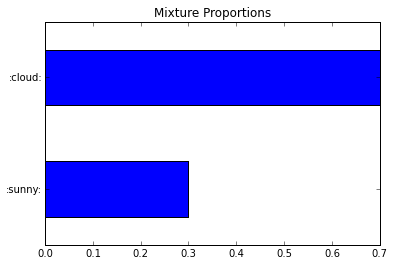

In [12]:
pd.Series(mixture_proportion, index=boring_topics).plot(kind='barh')
_=plt.title("Mixture Proportions")

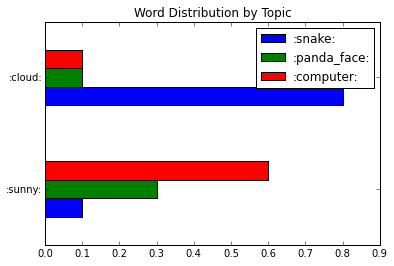

In [13]:
pd.DataFrame(topics, columns=boring_vocabulary, index=boring_topics).plot(kind='barh')
_=plt.title("Word Distribution by Topic")

    ➡ Forward Sampling
    
Let's generate some documents!

In [14]:
for doc_index in range(1, 11):
    topic = np.random.choice(topic_labels, p=mixture_proportion)
    doc_len = poisson(mu=10).rvs(size=1)
    doc = sorted([np.random.choice(vocabulary, 
                                   p=topics[topic_labels.index(topic)]) 
                  for _ in range(doc_len)])
    print("Document {:02d} (topic {}): {}".format(doc_index, topic, ''.join(doc)))

Document 01 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍📊📊
Document 02 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍
Document 03 (topic ☁): 🐍🐍🐍🐍🐼📊
Document 04 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼🐼📊📊
Document 05 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐼📊📊📊
Document 06 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍📊
Document 07 (topic ☀): 🐍🐼🐼🐼📊📊📊📊📊📊📊
Document 08 (topic ☁): 🐍🐍🐍🐍🐍🐼🐼📊
Document 09 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼
Document 10 (topic ☁): 🐍🐍🐍🐍📊


/Users/tdhopper/miniconda/envs/understanding-lda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


    """
    ⬅ Reversing the Process
    """

Given a collection of documents...

...find the topic for each document

...find the distribution over topics

...find the distribution over terms for each topic

    """
    ⬅ Limitations of this Model
    """
    
* Word order irrelevant. (Bag-of-words assumption!)
    * Ignores all linguistic structure!
* Single topic per document.
* Assumes we know # of topics!

```
➡ What if we sample the topic for each word?
```

In [15]:
docs = defaultdict(lambda: defaultdict(str))
for doc_index in range(10):
    doc_len = poisson(mu=10).rvs(size=1)
    mixture_proportion = dirichlet([0.5, 0.5]).rvs()[0]
    
    for word in range(doc_len):
        topic = np.random.choice(topic_labels, 
                                 p=mixture_proportion)
        word_dist = topics[topic_labels.index(topic)]
        word = np.random.choice(vocabulary, 
                                p=word_dist)
        docs[doc_index+1][topic] += word
        docs[doc_index+1][topic] = ''.join(sorted(docs[doc_index+1][topic]))

/Users/tdhopper/miniconda/envs/understanding-lda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [16]:
for doc_id, doc in docs.items():
    print("Doc {:02d}".format(doc_id))
    for topic, words in doc.items():
        print("  Words from topic {}: {}".format(topic, words))

Doc 01
  Words from topic ☀: 🐍🐼🐼🐼🐼🐼🐼📊📊📊📊📊
  Words from topic ☁: 🐍
Doc 02
  Words from topic ☁: 🐍🐍🐍🐍🐍🐍🐍🐍📊
Doc 03
  Words from topic ☀: 📊📊📊
  Words from topic ☁: 🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼🐼
Doc 04
  Words from topic ☀: 🐍🐼🐼📊📊📊📊📊
  Words from topic ☁: 🐍🐍🐼
Doc 05
  Words from topic ☁: 🐍🐍🐍🐍🐼📊📊📊📊
Doc 06
  Words from topic ☀: 🐼
  Words from topic ☁: 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼
Doc 07
  Words from topic ☀: 🐍🐍🐍🐼🐼🐼📊📊📊📊📊📊📊
  Words from topic ☁: 🐍🐍📊
Doc 08
  Words from topic ☀: 📊📊
  Words from topic ☁: 🐍🐍🐍🐍
Doc 09
  Words from topic ☀: 🐼🐼
  Words from topic ☁: 🐍🐍🐍🐍🐍🐼📊📊
Doc 10
  Words from topic ☀: 🐼📊📊
  Words from topic ☁: 🐍🐍🐍🐍🐍🐍🐍🐍📊
